# Eksperimen 1 — Pengaruh Stemming pada Preprocessing (Non-Stemming vs Stemming)


In [2]:
# Import library utama
import re
import pandas as pd
import numpy as np
import inflect
from nltk.stem import PorterStemmer

# HuggingFace + ONNX
from transformers import AutoTokenizer


# TensorFlow / Keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Dense, Dropout, GlobalMaxPooling1D, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# Evaluasi
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt


c:\Users\User\Desktop\Skripsi\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
# === Setting tampilan Pandas agar teks terlihat semua===
import pandas as pd

# tampilkan teks full (tidak dipotong dengan ...)
pd.set_option("display.max_colwidth", None)

# tampilkan lebih banyak baris (default 10)
pd.set_option("display.max_rows", 100)

# tampilkan lebih banyak kolom kalau DataFrame lebar
pd.set_option("display.max_columns", 20)

print("Pandas display options set: full text, max_rows=100, max_columns=20")


Pandas display options set: full text, max_rows=100, max_columns=20


In [4]:
# Inisialisasi inflect
p = inflect.engine()

def convert_numbers_to_words(text):
    return " ".join([p.number_to_words(w) if w.isdigit() else w for w in str(text).split()])

def clean_text(text: str) -> str:
    text = str(text).lower()
    text = re.sub(r"[^a-z0-9\s]", " ", text)
    text = re.sub(r"\s+", " ", text).strip()
    text = convert_numbers_to_words(text)
    return text

# Load dataset
train_raw = pd.read_csv(r"C:\Users\User\Desktop\Skripsi\Program_Skripsi\Eksperimen1\data\dreaddit-train.csv")
test_raw  = pd.read_csv(r"C:\Users\User\Desktop\Skripsi\Program_Skripsi\Eksperimen1\data\dreaddit-test.csv")

# Cleaning
train_clean = train_raw.copy()
test_clean  = test_raw.copy()
train_clean["cleaned_text"] = train_clean["text"].map(clean_text)
test_clean["cleaned_text"]  = test_clean["text"].map(clean_text)

# Variabel khusus untuk teks bersih
X_train_text_nonstem = train_clean["cleaned_text"].tolist()
X_test_text_nonstem  = test_clean["cleaned_text"].tolist()
y_train = train_clean["label"].to_numpy()
y_test  = test_clean["label"].to_numpy()

train_clean[["text","cleaned_text","label"]].head()


,text,cleaned_text,label
0,"He said he had not felt that way before, suggeted I go rest and so ..TRIGGER AHEAD IF YOUI'RE A HYPOCONDRIAC LIKE ME: i decide to look up ""feelings of doom"" in hopes of maybe getting sucked into some rabbit hole of ludicrous conspiracy, a stupid ""are you psychic"" test or new age b.s., something I could even laugh at down the road. No, I ended up reading that this sense of doom can be indicative of various health ailments; one of which I am prone to.. So on top of my ""doom"" to my gloom..I am now f'n worried about my heart. I do happen to have a physical in 48 hours.",he said he had not felt that way before suggeted i go rest and so trigger ahead if youi re a hypocondriac like me i decide to look up feelings of doom in hopes of maybe getting sucked into some rabbit hole of ludicrous conspiracy a stupid are you psychic test or new age b s something i could even laugh at down the road no i ended up reading that this sense of doom can be indicative of various health ailments one of which i am prone to so on top of my doom to my gloom i am now f n worried about my heart i do happen to have a physical in forty-eight hours,1
1,"Hey there r/assistance, Not sure if this is the right place to post this.. but here goes =) I'm currently a student intern at Sandia National Labs and working on a survey to help improve our marketing outreach efforts at the many schools we recruit at around the country. We're looking for current undergrad/grad STEM students so if you're a STEM student or know STEM students, I would greatly appreciate if you can help take or pass along this short survey. As a thank you, everyone who helps take the survey will be entered in to a drawing for chance to win one of three $50 Amazon gcs.",hey there r assistance not sure if this is the right place to post this but here goes i m currently a student intern at sandia national labs and working on a survey to help improve our marketing outreach efforts at the many schools we recruit at around the country we re looking for current undergrad grad stem students so if you re a stem student or know stem students i would greatly appreciate if you can help take or pass along this short survey as a thank you everyone who helps take the survey will be entered in to a drawing for chance to win one of three fifty amazon gcs,0
2,"My mom then hit me with the newspaper and it shocked me that she would do this, she knows I don't like play hitting, smacking, striking, hitting or violence of any sort on my person. Do I send out this vibe asking for it from the universe? Then yesterday I decided to take my friend to go help another ""friend"" move to a new place. While we were driving the friend we are moving strikes me on my shoulder. And I address it immediately because this is the 4th time I have told him not to do these things, then my other friend who is driving nearly gets into an collision with another car i think because he was high on marijuana and the friend we are moving in the backseat is like ""you have to understand I was just trying to get your attention"" you know the thing 5 year olds do to get peoples attention by smacking them, this guy is in his 60's.",my mom then hit me with the newspaper and it shocked me that she would do this she knows i don t like play hitting smacking striking hitting or violence of any sort on my person do i send out this vibe asking for it from the universe then yesterday i decided to take my friend to go help another friend move to a new place while we were driving the friend we are moving strikes me on my shoulder and i address it immediately because this is the 4th time i have told him not to do these things then my other friend who is driving nearly gets into an collision with another car i think because he was high on marijuana and the friend we are moving in the backseat is like you have to understand i was just trying to get your attention you know the thing five year olds do to get peoples attention by sm

In [5]:
ps = PorterStemmer()

def stem_sentence(text: str) -> str:
    return " ".join(ps.stem(w) for w in str(text).split())

train_clean["cleaned_text_stemmed"] = train_clean["cleaned_text"].map(stem_sentence)
test_clean["cleaned_text_stemmed"]  = test_clean["cleaned_text"].map(stem_sentence)

# Variabel khusus untuk teks stemmed
X_train_text_stem = train_clean["cleaned_text_stemmed"].tolist()
X_test_text_stem  = test_clean["cleaned_text_stemmed"].tolist()

train_clean[["cleaned_text","cleaned_text_stemmed"]].head()

,cleaned_text,cleaned_text_stemmed
0,he said he had not felt that way before sugget...,he said he had not felt that way befor sugget ...
1,hey there r assistance not sure if this is the...,hey there r assist not sure if thi is the righ...
2,my mom then hit me with the newspaper and it s...,my mom then hit me with the newspap and it sho...
3,until i met my new boyfriend he is amazing he ...,until i met my new boyfriend he is amaz he is ...
4,october is domestic violence awareness month a...,octob is domest violenc awar month and i am a ...


In [6]:
import torch
from transformers import AutoTokenizer, AutoModel

HF_MODEL_NAME = "mental/mental-bert-base-uncased"
MAX_LEN = 128

# Load tokenizer & model MentalBERT
tokenizer = AutoTokenizer.from_pretrained(HF_MODEL_NAME)
model = AutoModel.from_pretrained(HF_MODEL_NAME)

def get_embeddings(texts):
    embs = []
    for t in texts:
        enc = tokenizer(
            t, max_length=MAX_LEN,
            truncation=True, padding="max_length",
            return_tensors="pt"
        )
        with torch.no_grad():
            out = model(**enc)
        cls = out.last_hidden_state[:,0,:].numpy()  # ambil token [CLS]
        embs.append(cls)
    stacked = np.vstack(embs)              # (N,768)
    return np.expand_dims(stacked, axis=1) # (N,1,768)

# Ekstraksi embedding Non-Stem dan Stem
X_train_nonstem = get_embeddings(X_train_text_nonstem)
X_test_nonstem  = get_embeddings(X_test_text_nonstem)

X_train_stem = get_embeddings(X_train_text_stem)
X_test_stem  = get_embeddings(X_test_text_stem)

print("Non-Stem shape:", X_train_nonstem.shape, X_test_nonstem.shape)
print("Stem shape:", X_train_stem.shape, X_test_stem.shape)

c:\Users\User\Desktop\Skripsi\.venv\Lib\site-packages\huggingface_hub\file_download.py:945: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of BertModel were not initialized from the model checkpoint at mental/mental-bert-base-uncased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Non-Stem shape: (2838, 1, 768) (715, 1, 768)
Stem shape: (2838, 1, 768) (715, 1, 768)


In [7]:
def build_cnn(input_shape):
    model = Sequential([
        Conv1D(128, 1, activation='relu', input_shape=input_shape),
        BatchNormalization(),
        GlobalMaxPooling1D(),
        Dropout(0.6),
        Dense(64, activation='relu', kernel_regularizer=l2(0.01)),
        BatchNormalization(),
        Dropout(0.6),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=Adam(1e-3), loss="binary_crossentropy", metrics=["accuracy"])
    return model

In [8]:
# Jalankan Epoch (Training)
def train_eval(X_train, y_train, X_test, y_test, title=""):
    model = build_cnn((1,768))
    es = EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)
    rl = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2)
    ck = ModelCheckpoint(f"best_{title}.h5", save_best_only=True)
    
    hist = model.fit(
        X_train, y_train,
        validation_split=0.2,
        epochs=20,
        batch_size=8,
        callbacks=[es, rl, ck],
        verbose=1
    )
    return model, hist

# Training Non-Stem
model_nonstem, hist_nonstem = train_eval(X_train_nonstem, y_train, X_test_nonstem, y_test, "NonStem")

# Training Stem
model_stem, hist_stem = train_eval(X_train_stem, y_train, X_test_stem, y_test, "Stem")


Epoch 1/20


284/284 [==============================] - 3s 4ms/step - loss: 1.3280 - accuracy: 0.6656 - val_loss: 0.8978 - val_accuracy: 0.7905 - lr: 0.0010
Epoch 2/20
 18/284 [>.............................] - ETA: 0s - loss: 1.0233 - accuracy: 0.7292

c:\Users\User\Desktop\Skripsi\.venv\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


284/284 [==============================] - 1s 4ms/step - loss: 1.0045 - accuracy: 0.7282 - val_loss: 0.7403 - val_accuracy: 0.8046 - lr: 0.0010
Epoch 3/20
284/284 [==============================] - 1s 3ms/step - loss: 0.8516 - accuracy: 0.7419 - val_loss: 0.6343 - val_accuracy: 0.8204 - lr: 0.0010
Epoch 4/20
284/284 [==============================] - 1s 3ms/step - loss: 0.7665 - accuracy: 0.7489 - val_loss: 0.5747 - val_accuracy: 0.8310 - lr: 0.0010
Epoch 5/20
284/284 [==============================] - 1s 3ms/step - loss: 0.6788 - accuracy: 0.7595 - val_loss: 0.5397 - val_accuracy: 0.8292 - lr: 0.0010
Epoch 6/20
284/284 [==============================] - 1s 3ms/step - loss: 0.6353 - accuracy: 0.7753 - val_loss: 0.4951 - val_accuracy: 0.8292 - lr: 0.0010
Epoch 7/20
284/284 [==============================] - 1s 3ms/step - loss: 0.5797 - accuracy: 0.7749 - val_loss: 0.4628 - val_accuracy: 0.8380 - lr: 0.0010
Epoch 8/20
284/284 [==============================] - 1s 3ms/step - loss: 0.5595 

23/23 [==============================] - 0s 2ms/step
== Non-Stemming ==
                precision    recall  f1-score   support

Not Depression       0.83      0.76      0.79       346
    Depression       0.79      0.85      0.82       369

      accuracy                           0.81       715
     macro avg       0.81      0.80      0.80       715
  weighted avg       0.81      0.81      0.81       715



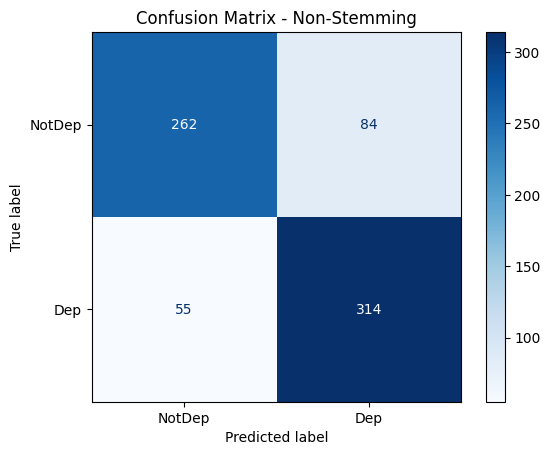

23/23 [==============================] - 0s 2ms/step
== Stemming ==
                precision    recall  f1-score   support

Not Depression       0.75      0.67      0.71       346
    Depression       0.72      0.79      0.75       369

      accuracy                           0.73       715
     macro avg       0.73      0.73      0.73       715
  weighted avg       0.73      0.73      0.73       715



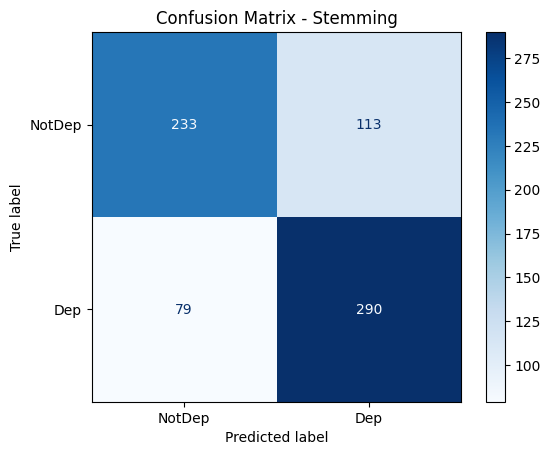

In [9]:
# Evaluasi
def evaluate_model(model, X_test, y_test, title=""):
    preds = (model.predict(X_test) >= 0.5).astype(int).ravel()
    print(f"== {title} ==")
    print(classification_report(y_test, preds, target_names=["Not Depression","Depression"]))
    cm = confusion_matrix(y_test, preds)
    disp = ConfusionMatrixDisplay(cm, display_labels=["NotDep","Dep"])
    disp.plot(cmap="Blues"); plt.title(f"Confusion Matrix - {title}"); plt.show()

evaluate_model(model_nonstem, X_test_nonstem, y_test, "Non-Stemming")
evaluate_model(model_stem, X_test_stem, y_test, "Stemming")

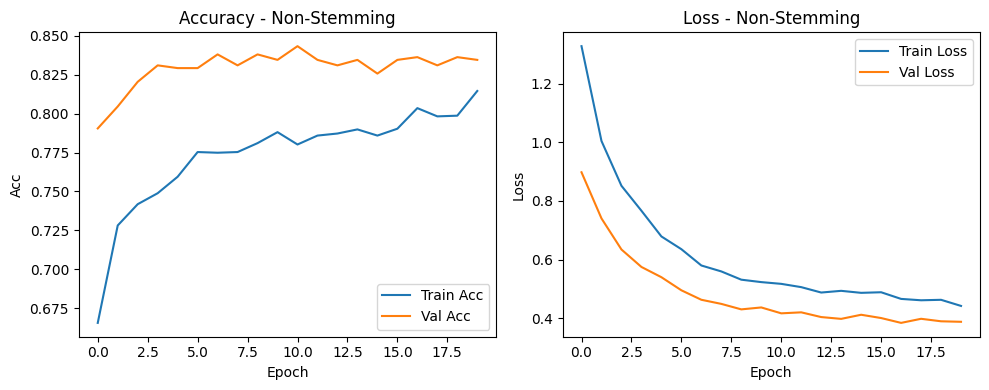

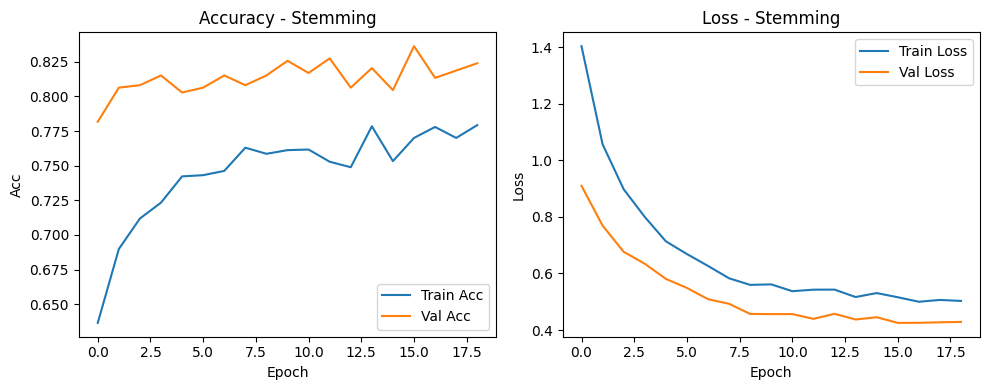

In [10]:
# visualisasi
def plot_training_history(history, title=""):
    plt.figure(figsize=(10,4))
    # accuracy
    plt.subplot(1,2,1)
    plt.plot(history.history.get("accuracy",[]), label="Train Acc")
    plt.plot(history.history.get("val_accuracy",[]), label="Val Acc")
    plt.title(f"Accuracy - {title}"); plt.xlabel("Epoch"); plt.ylabel("Acc"); plt.legend()
    # loss
    plt.subplot(1,2,2)
    plt.plot(history.history.get("loss",[]), label="Train Loss")
    plt.plot(history.history.get("val_loss",[]), label="Val Loss")
    plt.title(f"Loss - {title}"); plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend()
    plt.tight_layout(); plt.show()

plot_training_history(hist_nonstem, "Non-Stemming")
plot_training_history(hist_stem, "Stemming")
